In [39]:
%matplotlib inline

In [40]:
import math 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

import cvxpy as cp

from tqdm.notebook import trange

In [41]:
plt.style.use('scientific')

In [42]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.optim.gmp import observation_block_forward, equality_block
from rsnn.optim.nuv import binary_prior, box_prior, pnorm_prior, laplace_prior, half_space_prior, plain_prior
from rsnn.optim.cost import box_cost, half_space_cost, plain_cost, laplace_cost, pnorm_cost
from rsnn.spike_train.measure import single_channel_correlation
from rsnn.utils.utils import cyclic_after, cyclic_before, cyclic_neighborhood

In [43]:
rng = np.random.default_rng()

# Supervised Learning for Spiking Neurons

In [22]:
num_inputs = 250 # number of synapses
delays = rng.uniform(1.0, 20.0, num_inputs)
synapse_beta, soma_decay = 4, 5
firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 100.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [23]:
times = np.linspace(0, period, 10000)

In [24]:
def input_spike_resp(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))

def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

In [25]:
def potential(t, delays, weights):
    y = np.array([
        np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None]) % period), axis=0) for k in range(num_inputs)
    ])
    return weights@y

In [26]:
def potential_deriv(t, delays, weights):
    y = np.array([
        np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None]) % period), axis=0) for k in range(num_inputs)
    ])
    return weights@y

In [27]:
def threshold(t):
    return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None]) % period), axis=0)

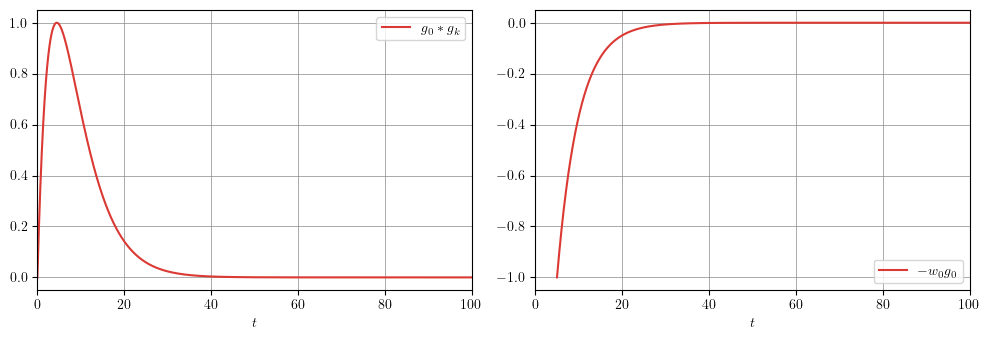

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(times, input_spike_resp(times), c="C1", label=r"$g_0 * g_k$")
axes[1].plot(times, refractory_spike_resp(times), c="C1", label=r"$-w_0 g_0$")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$t$")
axes[0].set_xlim(0, period)
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, period)
fig.tight_layout()

In [29]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period)

In [30]:
input_spike_trains = spike_train_generator.rand(period, num_inputs)
target_spike_train = spike_train_generator.rand(period)

Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

In [31]:
num_spikes = np.array([spike_train.num_spikes for spike_train in input_spike_trains.spike_trains])

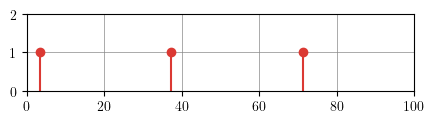

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.stem(target_spike_train.firing_times, np.ones_like(target_spike_train.firing_times), basefmt=" ", markerfmt="C1o", linefmt="C1-")
ax.set_xlim(0, period)
ax.set_ylim(0, 2)
plt.show()

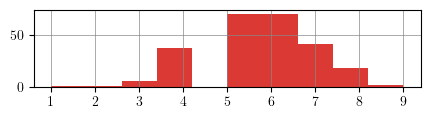

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.hist(num_spikes, color="C1")
plt.show()

# Computing Weights

In [37]:
def compute_template(input_spike_trains, target_spike_train, max_level, firing_region, min_slope, time_step):
    yf, ys, yl = [], [], []
    zf, zs, zl = [], [], []
    
    # equality at firing times
    for t in target_spike_train.firing_times:
        yf.append(
            np.array(
                [np.sum(input_spike_resp(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zf.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the firing threshold everywhere (except during the absolute refractory period)
    for t in cyclic_after(target_spike_train.firing_times, period, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the maximum level not close to firing (except during the absolute refractory period)
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(max_level - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # slope larger than the minimum slope close to firing
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, firing_region, time_step):
        ys.append(
            np.array(
                [np.sum(input_spike_resp_deriv(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zs.append(min_slope)
        
    return np.vstack(yf), np.array(zf), np.vstack(yl), np.array(zl), np.vstack(ys), np.array(zs) 

In [44]:
num_optimal = 0
wcp = cp.Variable(num_inputs)
objective = cp.Minimize(0.0)

for _ in trange(100):
    input_spike_trains = spike_train_generator.rand(period, num_inputs)
    target_spike_train = spike_train_generator.rand(period)
    yf, zf, yl, zl, ys, zs = compute_template(input_spike_trains, target_spike_train, firing_threshold - 0.5, 1.0, 0.5, 0.2)
    constraints = [
        yf @ wcp == zf, 
        yl @ wcp <= zl, 
        ys @ wcp >= zs, 
        wcp >= wmin, 
        wcp <= wmax
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == "optimal":
        num_optimal += 1

num_optimal

  0%|          | 0/100 [00:00<?, ?it/s]

Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

ok


Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

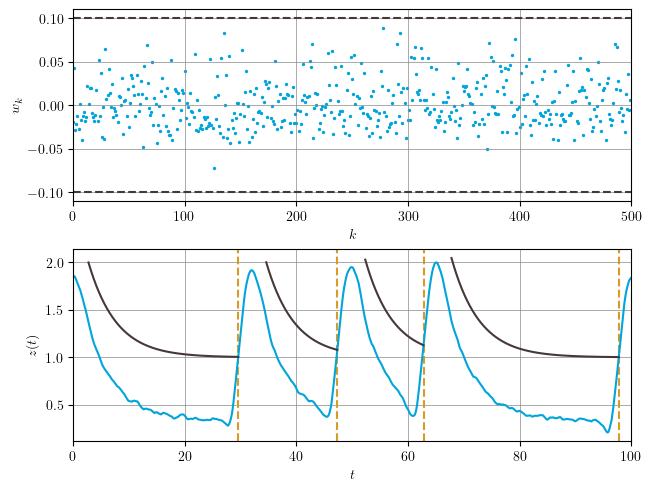

In [71]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wcp.value, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wcp.value), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Bounded Weights with L2 Regularization

In [75]:
wcp = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm2(wcp))
constraints = [
    yf @ wcp == zf, 
    yl @ wcp <= zl, 
    ys @ wcp >= zs, 
    wcp >= wmin, 
    wcp <= wmax
]
prob = cp.Problem(objective, constraints)
prob.solve();
prob.status

'optimal'

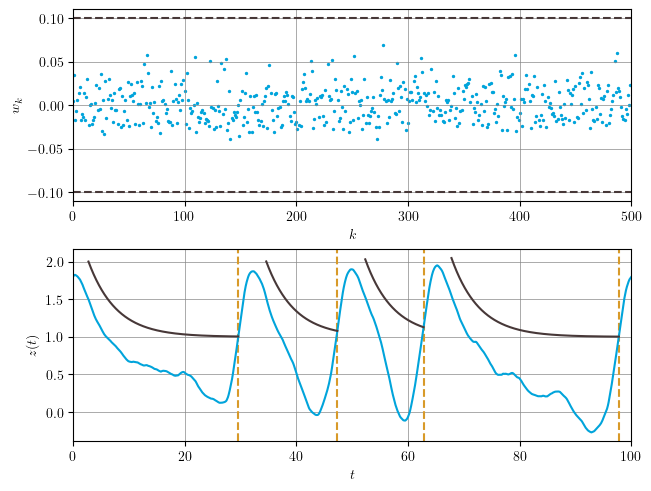

In [76]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wcp.value, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wcp.value), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Bounded Weights with L1 Regularization

In [77]:
wcp = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm1(wcp))
constraints = [
    yf @ wcp == zf, 
    yl @ wcp <= zl, 
    ys @ wcp >= zs, 
    wcp >= wmin, 
    wcp <= wmax
]
prob = cp.Problem(objective, constraints)
prob.solve();
prob.status

'optimal'

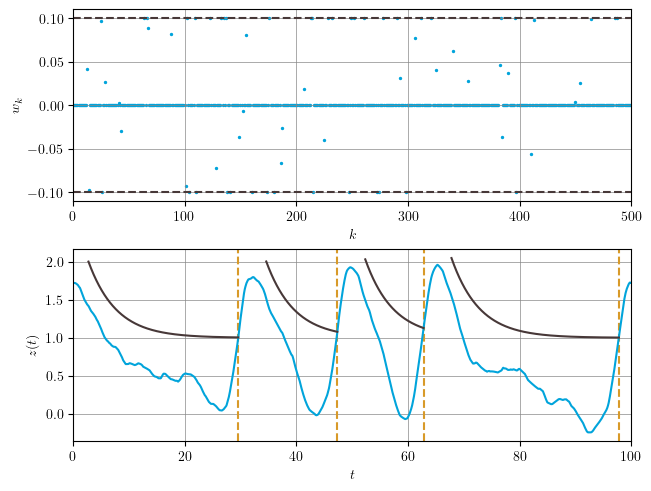

In [78]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wcp.value, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wcp.value), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

## Binary Weights

In [ ]:
wtcp = cp.Variable(num_inputs, integer=True)
objective = cp.Minimize(0.0)
constraints = [
    yf @ wtcp == 10*zf, 
    yl @ wtcp <= 10*zl, 
    ys @ wtcp >= 10*zs, 
    wtcp >= -1.0, 
    wtcp <= 1.0
]
prob = cp.Problem(objective, constraints)
prob.solve(solver="GUROBI");
prob.status

In [ ]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wtcp.value/20, s=2, c="C2", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C0")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C0")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C4")
_ = axes_template[1].plot(times, potential(times, delays, wtcp.value/20), c="C2", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times), c="C0")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")